In [8]:
import os
import shutil
from random import shuffle

import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.applications import xception
from tensorflow.keras.layers import Dense, Input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [9]:
data_dir = os.listdir("data") #data has manually been unzipped

def make_folders_train(type):
    '''Makes folders for trainining and test sets
        makes folder per species '''
    path = f'visual_data/{type}_images'
    if not os.path.isdir(path):
        os.makedirs(path)

    classes = [f'dogs_{type}', f'cats_{type}',
               f'horses_{type}', f'humans_{type}']
    for c in classes:
        p = os.path.join(path, c)
        if not os.path.isdir(p):
            os.mkdir(p)


types = ['train', 'test']
for type in types:
    make_folders_train(type)


def create_sets(size=0.9):
    #puts training images , split according to size parameters,store in its respective folders
    for f in data_dir:
        path = os.path.join('data', f)
        imgs = os.listdir(path)
        split_set = int(len(imgs) * size)

        test = imgs[split_set:]
        train = imgs[:split_set]
        for img_test in test:
            test_path = os.path.join(
                'visual_data\\test_images\\' + f.lower() + '_test', img_test)
            img_test = os.path.join(path, img_test)

            shutil.copyfile(img_test, test_path)

        for img_train in train:
            train_path = os.path.join(
                'visual_data\\train_images\\' + f.lower() + '_train', img_train)
            img_train = os.path.join(path, img_train)
            shutil.copyfile(img_train, train_path)


create_sets()

In [10]:

print('-' * 60)
print("Test Data")
p = 'visual_data\\test_images'
for f in os.listdir(p):
    print(f'{f} {len(os.listdir(os.path.join(p, f)))}')
print('-' * 60)
print("Train Data")
p = 'visual_data\\train_images'
for f in os.listdir(p):
    print(f'{f} {len(os.listdir(os.path.join(p, f)))}')


------------------------------------------------------------
Test Data
cats_test 21
dogs_test 21
horses_test 21
humans_test 21
------------------------------------------------------------
Train Data
cats_train 181
dogs_train 181
horses_train 181
humans_train 181


In [11]:

IMG_SIZE= 224
img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

#Data augmentation
train_gen = ImageDataGenerator(rescale=1.0/255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True)

val_gen = ImageDataGenerator(rescale=1.0/255)

#Train set generator
train_generator = train_gen.flow_from_directory(
    "visual_data\\train_images",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')
#validation set generator
val_generator = val_gen.flow_from_directory(
    "visual_data\\test_images",
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical')


Found 724 images belonging to 4 classes.
Found 84 images belonging to 4 classes.


In [16]:
model = xception.Xception(include_top=True, weights='imagenet',
                          input_tensor=img_input, classes=1000, classifier_activation='softmax')
model.summary()

last_layer = model.get_layer('avg_pool').output
x = Flatten(name='Flatten')(last_layer)
x =   Dense(64, activation='relu')(x)
x =   Dense(32, activation='relu')(x)
out = Dense(4, activation='softmax',name='output')(x)
model = Model(img_input, out)
for layer in model.layers[:-3]:
    layer.trainable = False
model.summary()

model.compile(optimizer='adam', metrics=[
              'accuracy'], loss='categorical_crossentropy')

my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='xception_model_2.h5', save_best_only=True),
]

history = model.fit_generator(train_generator, epochs=20, validation_data=val_generator, callbacks=my_callbacks )

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

C:\Users\jeron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
23/23 [==============================] - 38s 2s/step - loss: 0.7328 - accuracy: 0.7920 - val_loss: 0.1669 - val_accuracy: 0.9643
Epoch 2/20
23/23 [==============================] - 36s 2s/step - loss: 0.1057 - accuracy: 0.9727 - val_loss: 0.0876 - val_accuracy: 0.9762
Epoch 3/20
23/23 [==============================] - 40s 2s/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0961 - val_accuracy: 0.9643
Epoch 4/20
23/23 [==============================] - 41s 2s/step - loss: 0.0422 - accuracy: 0.9813 - val_loss: 0.0710 - val_accuracy: 0.9881
Epoch 5/20
23/23 [==============================] - 37s 2s/step - loss: 0.0327 - accuracy: 0.9922 - val_loss: 0.0738 - val_accuracy: 0.9881
Epoch 6/20
23/23 [==============================] - 37s 2s/step - loss: 0.0287 - accuracy: 0.9911 - val_loss: 0.0792 - val_accuracy: 0.9881
Epoch 7/20
23/23 [==============================] - 36s 2s/step - loss: 0.0313 - accuracy: 0.9869 - val_loss: 0.0671 - val_accuracy: 0.9762
Epoch 8/20
23/23 [==

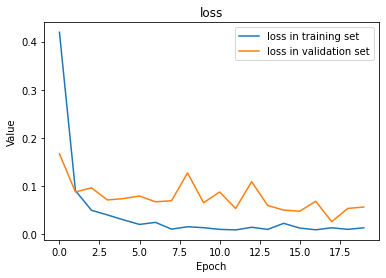

In [17]:
def plot_curve(metric, save=False, saveas='test'):
    '''Plots the learning curve for the model
    based on history, metric takes any acceptable metric
    by the model e.g. Loss, if save is set to true
    saves a copy of the graph under the name specified
    in saveas by default is test'''
    plt.plot(history.history[metric], label=f'{metric} in training set')
    plt.plot(history.history[f'val_{metric}'],
             label=f'{metric} in validation set')
    plt.title(metric)
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend()
    if save:
        plt.savefig(f'{saveas}')
    plt.show()
import matplotlib.pyplot as plt
plot_curve('loss')